In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from copy import deepcopy
import seaborn as sns
sns.set_theme()

from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy, Std
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.util.processes.HestonGenerator import HestonParameterSet, HestonGenerator
from src.deep_hedging.DeepHedgeHeston import DeepHedgeHeston, DeepHedgeHestonConfig
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.util.TimeUtil import UniformTimeDiscretization
from src.config import DEVICE

In [2]:
import ray
ray.init()

2022-12-13 21:53:45,085	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.8.0
Ray version:,2.0.1


# Evaluation - Heston

In [3]:
trading_freq: int = 5
uncertainty_aversion: float = 130
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)
hedge_objective = MeanVariance(uncertainty_aversion)

In [4]:
estimated_heston_parameters = HestonParameterSet(
    drift=0.0,
    reversion_level=0.04,
    reversion_speed=2,
    vol_of_vol=0.2,
    correlation=0.8,
)

In [5]:
estimated_generator = HestonGenerator(estimated_heston_parameters).provide_generator(
    initial_value=np.array([1.0, estimated_heston_parameters.reversion_level]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)
reference_paths = estimated_generator(2**16)

pen_config = SignatureConfig(depth=2, augmentations=[AddTimeComponent(td), LeadLag()])
penalizer = SigWassersteinMetric(reference_paths[:, :, 0:2], pen_config, transform=lambda x: 10000 * x)

## Test Data

In [6]:
pars_f = 'resources/uncertainty-test-sets/heston/pars_1_20_ex.npy'
pars_coarseness = int(pars_f.split('_')[2])
pars = np.load(pars_f, allow_pickle=True)
par_sets = [HestonParameterSet(
    drift=d['drift'],
    reversion_speed=d['reversion_speed'],
    reversion_level=d['_reversion_level'],
    vol_of_vol=d['_vol_of_vol'],
    correlation=d['_correlation'],
) for d in pars]

In [7]:
parameter_names = {'reversion_speed': 'Reversion Speed', '_reversion_level': 'Reverison Level', '_vol_of_vol': 'Vol of Vol', '_correlation': 'Correlation'}

In [8]:
pars_by_coarseness = {c: np.load(f'resources/uncertainty-test-sets/heston/{c}.npy', allow_pickle=True) for c in ('pars_1_20_50350_corrected_ex', 'pars_1_10_36957_corrected_ex', 'pars_1_100_38459_corrected')}

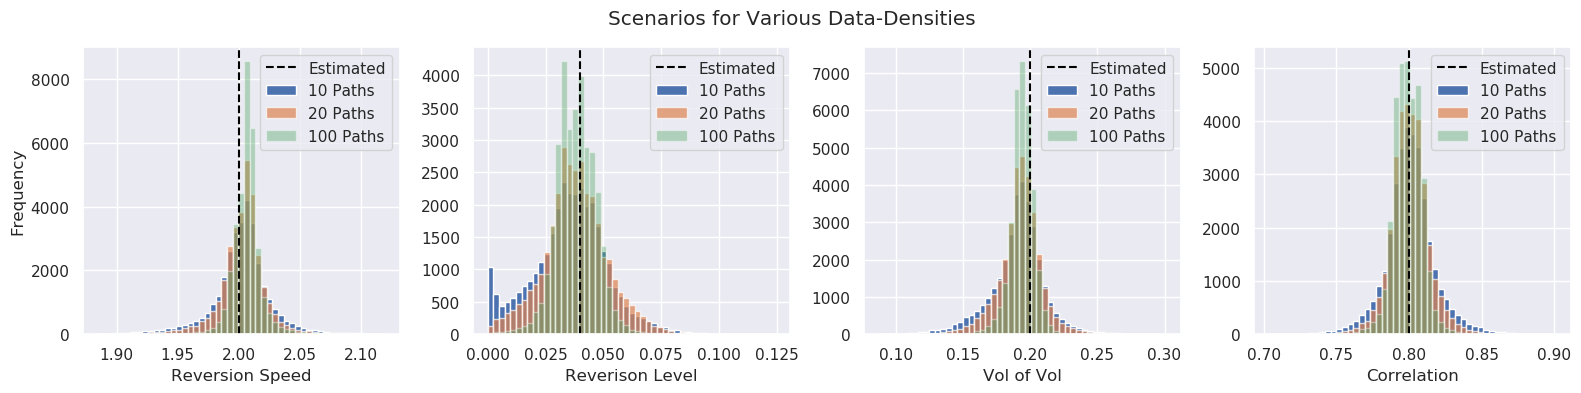

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for k, ax in zip(list(pars[0].keys())[1:], axs):
    _, bins = np.histogram([d[k] for l in pars_by_coarseness.values() for d in l[:2**15]], bins=51)
    ax.hist([d[k] for d in pars_by_coarseness['pars_1_10_36957_corrected_ex']][:2**15], bins=bins, alpha=1., label='10 Paths')
    ax.hist([d[k] for d in pars_by_coarseness['pars_1_20_50350_corrected_ex']][:2**15], bins=bins, alpha=.7, label='20 Paths')
    ax.hist([d[k] for d in pars_by_coarseness['pars_1_100_38459_corrected']][:2**15], bins=bins, alpha=.4, label='100 Paths')
    ax.axvline(estimated_heston_parameters.__dict__[k if k[0] != '_' else k[1:]], c='black', ls='--', label='Estimated')
    ax.set_xlabel(parameter_names[k])
    if k == 'reversion_speed':
        ax.set_ylabel('Frequency')
    ax.legend()
# ax.set_yscale('log')
st = fig.suptitle('Scenarios for Various Data-Densities')
# st.set_y(1.0)
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('figs/HestonUncertaintyData.pdf')
plt.show()

### Test Generators

In [10]:
test_generators = [
    HestonGenerator(parameter=ps).provide_generator(
        initial_value=np.array([1.0, ps.reversion_level]),
        times=td.times,
        random_number_generator=np.random.default_rng(1111 + i),
        device='cpu',
    ) for i, ps in enumerate(par_sets)
]

In [11]:
@ray.remote
def generate(index, gen, number_of_paths):
    return index, gen(number_of_paths)

## Loading Deep Hedges and Robust Hedge GANs

In [12]:
target_folder = f'resources/network-states/test_h_new/ua{uncertainty_aversion:03}/tf_{trading_freq:02}'
target_folder

'resources/network-states/test_h_new/ua130/tf_05'

### Deep and Optimal Hedges

In [13]:
deep_hedge = DeepHedgeHeston(
    DeepHedgeHestonConfig(
        derivative=derivative,
        initial_information_value=torch.tensor([
                1.0,
                estimated_heston_parameters.reversion_level,
                HestonGenerator(parameter=estimated_heston_parameters).get_correction_term(td.maturity, estimated_heston_parameters.reversion_level),
            ], dtype=torch.float32, device=DEVICE),
        strategy_config=StrategyNetConfig(
            dim_of_information_process=2,
            dim_of_tradable_asset=2,
            number_of_layers=2,
            nodes_in_intermediate_layers=128,
        ),
    )
)
optimal_hedge = deepcopy(deep_hedge)

In [14]:
deep_hedge.load_state_dict(torch.load(f'{target_folder}/deep_hedge_post_trained.pt'))

<All keys matched successfully>

In [15]:
optimal_hedge.load_state_dict(torch.load(f'{target_folder}/optimal_hedge_pc{pars_coarseness}.pt'))

<All keys matched successfully>

### Robust Hedge GANs

In [29]:
penalty_scales = [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000, 30000]
[p/42 for p in penalty_scales]

[59.523809523809526,
 119.04761904761905,
 178.57142857142858,
 238.0952380952381,
 297.6190476190476,
 357.14285714285717,
 416.6666666666667,
 476.1904761904762,
 595.2380952380952,
 714.2857142857143]

In [17]:
rh_gans = {pen_s: deepcopy(deep_hedge) for pen_s in penalty_scales}

In [18]:
for pen_s in penalty_scales:
    rh_gans[pen_s].load_state_dict(torch.load(f'{target_folder}/v_sigw_{pen_s:05.0f}/rhgan_dh.pt'))

## Evaluating OOSP

In [19]:
no_to_display = 10000

In [20]:
dh_oosp_by_par = {}
oh_oosp_by_par = {}
rhgan_oosp_by_pen_by_par = {pen: {} for pen in penalty_scales}
distances_to_estimate_dict = {}
for indices in tqdm(np.array_split(np.arange(no_to_display), np.arange(48,no_to_display,48))):
    for i, paths in ray.get([generate.remote(index=i, gen=test_generators[i], number_of_paths=no_to_display) for i in indices]):
        paths = paths.cuda()
        increments = torch.diff(paths, 1, 1)
        dh_oosp_by_par[i] = hedge_objective(deep_hedge(increments)).cpu().item()
        oh_oosp_by_par[i] = hedge_objective(optimal_hedge(increments)).cpu().item()
        for pen in penalty_scales:
            rhgan_oosp_by_pen_by_par[pen][i] = hedge_objective(rh_gans[pen](increments)).cpu().item() 
        distances_to_estimate_dict[i] = penalizer(paths[:, :, 0:2]).item()

In [21]:
dh_oosps = [dh_oosp_by_par[i] for i in range(no_to_display)]
oh_oosps = [oh_oosp_by_par[i] for i in range(no_to_display)]
rhgan_oosps_by_pen = {pen: [rhgan_oosp_by_pen_by_par[pen][i] for i in range(no_to_display)] for pen in penalty_scales}
distances_to_estimate = [distances_to_estimate_dict[i] for i in range(no_to_display)]

In [22]:
print(f'                   Mean:       Std:')
print(f'Deep Hedge:        {np.mean(dh_oosps):.6f}    {np.std(dh_oosps):.6f}')
print(f'Opt. Hedge:        {np.mean(oh_oosps):.6f}    {np.std(oh_oosps):.6f}')
for pen in penalty_scales:
    print(f'Robust Hedge GAN:  {np.mean(rhgan_oosps_by_pen[pen]):.6f}    {np.std(rhgan_oosps_by_pen[pen]):.6f}')

                   Mean:       Std:
Deep Hedge:        0.052549    0.011990
Opt. Hedge:        0.052491    0.011792
Robust Hedge GAN:  0.053286    0.010994
Robust Hedge GAN:  0.052793    0.011230
Robust Hedge GAN:  0.052581    0.011440
Robust Hedge GAN:  0.052536    0.011503
Robust Hedge GAN:  0.052503    0.011586
Robust Hedge GAN:  0.052503    0.011609
Robust Hedge GAN:  0.052467    0.011686
Robust Hedge GAN:  0.052468    0.011745
Robust Hedge GAN:  0.052481    0.011777
Robust Hedge GAN:  0.052467    0.011823


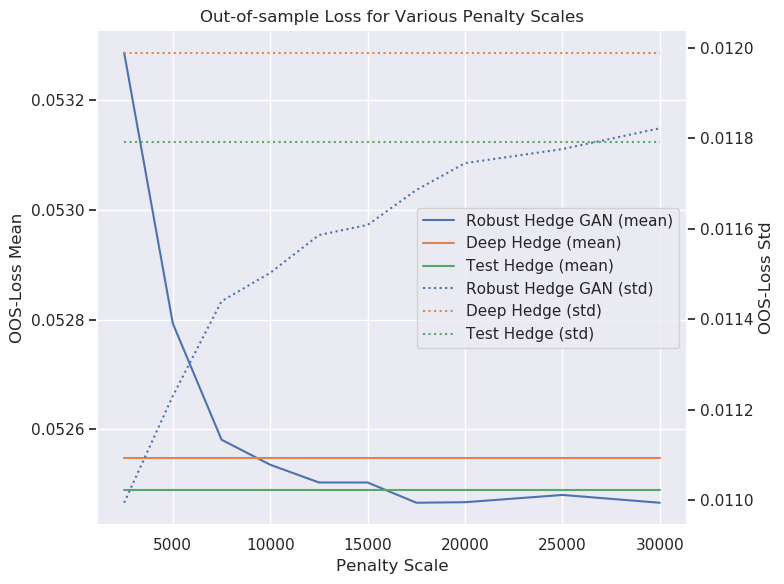

In [28]:
fig, axl = plt.subplots(figsize=(8,6))
axl.plot(penalty_scales, [np.mean(rhgan_oosps_by_pen[pen]) for pen in penalty_scales], label='Robust Hedge GAN (mean)')
axl.plot(penalty_scales, [np.mean(dh_oosps) for pen in penalty_scales], c='C1', label='Deep Hedge (mean)')
axl.plot(penalty_scales, [np.mean(oh_oosps) for pen in penalty_scales], c='C2', label='Test Hedge (mean)')
axl.set_title('Out-of-sample Loss for Various Penalty Scales')
axl.set_xlabel('Penalty Scale')
axl.set_ylabel('OOS-Loss Mean')

axr = axl.twinx()
axr.plot(penalty_scales, [np.std(rhgan_oosps_by_pen[pen]) for pen in penalty_scales], ls=':', label='Robust Hedge GAN (std)')
axr.plot(penalty_scales, [np.std(dh_oosps) for pen in penalty_scales], c='C1', ls=':', label='Deep Hedge (std)')
axr.plot(penalty_scales, [np.std(oh_oosps) for pen in penalty_scales], c='C2', ls=':', label='Test Hedge (std)')
axr.set_ylabel('OOS-Loss Std')
axr.grid(False)

lines, labels = axl.get_legend_handles_labels()
lines2, labels2 = axr.get_legend_handles_labels()
axr.legend(lines + lines2, labels + labels2, loc=5)
plt.tight_layout()
# plt.savefig('figs/HestonOOSPComparison.pdf')
plt.show()